In [2]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [11]:
import requests
from PIL import Image
from io import BytesIO
from IPython.display import Image as IPyImage

apiKey = '46b34ce194a04492b68926a28c2a629f'
# Get static map from Geoapify
def get_static_map(lat, lon, zoom, width=500, height=500, scale=1, format='jpeg', api_key=apiKey):
    url = "https://api.geoapify.com/v1/staticmap"
    params = {
        "style": "osm-carto",
        "width": width,
        "height": height,
        "zoom": zoom,
        "center": f"lonlat:{lon},{lat}",
        "scale": scale,
        "format": format,
        "apiKey": api_key
    }
    response = requests.get(url, params=params)
    return response.content

# Generate Dataset

In [12]:
import random

def random_point_in_bounding_box(latlon1, latlon2):
    lat1, lon1 = latlon1
    lat2, lon2 = latlon2
    lat = random.uniform(lat1, lat2)
    lon = random.uniform(lon1, lon2)
    return (lat, lon)

In [13]:
from datetime import datetime

# coordinates = [(40.7128, -74.0060), (51.5074, -0.1278), (-33.8651, 151.2094)]
latlon1 = (-17.0357, 122.9197)
latlon2 = (-30.3538, 145.7713)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
drive_folder = f'GoogleEarthEngineExport'

coordinates = []
while len(coordinates) < 5:
  point = random_point_in_bounding_box(latlon1, latlon2)
  coordinates.append(point)

f"dirname: {drive_folder}, bounding box {latlon1, latlon2} ,coordinates: {coordinates}"


'dirname: GoogleEarthEngineExport, bounding box ((-17.0357, 122.9197), (-30.3538, 145.7713)) ,coordinates: [(-19.167845509591817, 128.64545222434143), (-29.964688852725555, 140.51840311369457), (-22.355166770019824, 133.96264046684837), (-19.496448360741105, 136.24815793298194), (-24.28828993259039, 141.69030251172785)]'

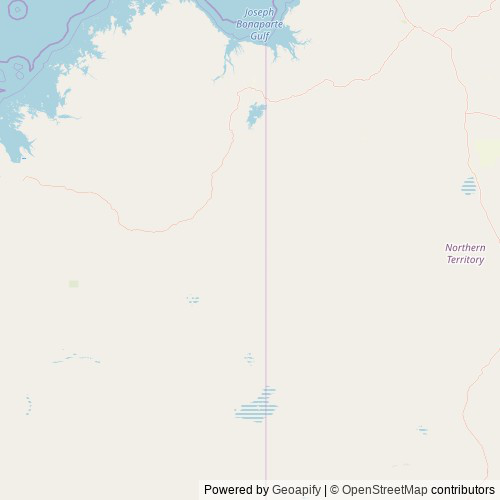

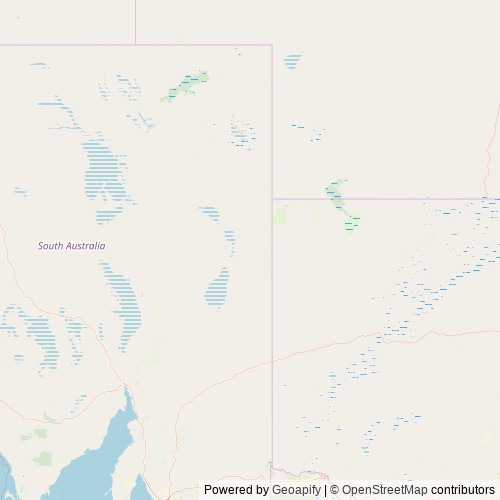

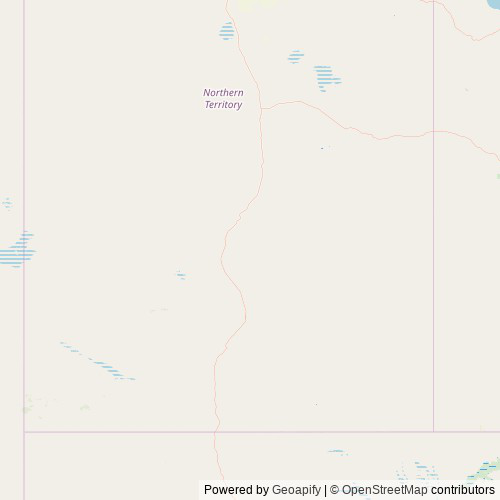

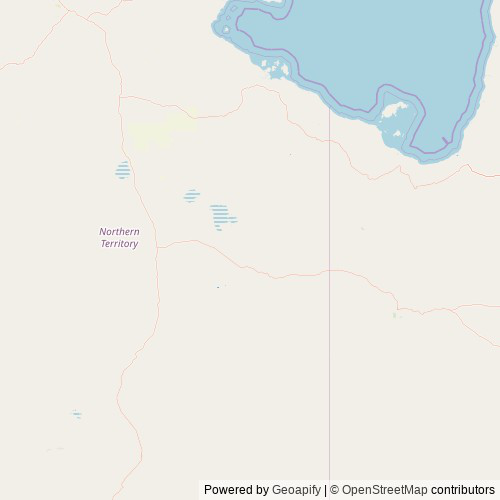

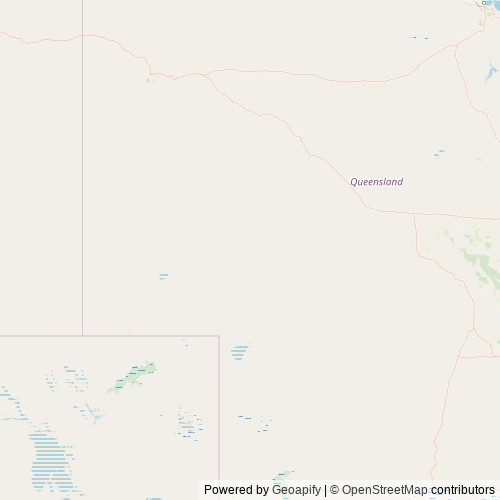

In [14]:
import time
# display static map of coordinates
for coordinate in coordinates:
  lat, lon = coordinate
  img = get_static_map(lat, lon, 5)
  img = Image.open(BytesIO(img))
  display(img)
  time.sleep(0.5)

In [21]:
def fetch_elevation(coordinates, folder, buffer):
    tasks = []
    
    # Loop over the list of coordinates
    for i, coord in enumerate(coordinates):
        # Extract the latitude and longitude from the coordinate tuple
        lat, lon = coord
        
        # Fetch the elevation data for the current coordinate
        elv_image = ee.Image('USGS/SRTMGL1_003').clip(ee.Geometry.Point(lon, lat).buffer(buffer))
        
        # filename including coordinates
        # filename = f'projects/elevation/{i}/{lat:.4f}_{lon:.4f}_{ct.strftime("%Y%m%d_%H%M%S")}'.replace(".", "-")
        filename = f'color_{i}_{lat}_{lon}_{ct.strftime("%Y%m%d_%H%M%S")}'
        # Create a task to export the image to Google Drive
        task = ee.batch.Export.image.toDrive(image=elv_image,
                                              description=f'elevation_{i}',
                                              folder=folder,
                                              fileNamePrefix=filename,
                                              region=elv_image.geometry().bounds().getInfo()['coordinates'],
                                              scale=30)

        # # task = ee.batch.Export.image.toAsset(
        # #                                       image=elv_image,
        # #                                       description=f'elevation_{i}',
        # #                                       assetId=filename,
        # #                                       region=elv_image.geometry().bounds().getInfo()['coordinates'],
        # #                                       scale=30)
        
        # Start the export task
        task.start()
        
        # Add the task to the list of tasks
        tasks.append(task)
    
    # Return the list of export tasks
    return tasks

In [22]:
import datetime
ct = datetime.datetime.now()

def export_region_around_coordinate(coordinates, folder, buffer):
    tasks = []
    
    # Loop over the list of coordinates
    for i, coord in enumerate(coordinates):
        latitude, longitude = coord
        # Define a point for the given coordinate
        point = ee.Geometry.Point([longitude, latitude])

        # Load the Sentinel-2 surface reflectance image collection for the date range of interest
        collection = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filterBounds(point) \
            .filterDate('2020-01-01', '2020-12-31')

        # Filter out cloudy pixels
        filteredCollection = collection \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

        # Select the first image in the filtered collection
        image = filteredCollection.first()
        image = image.select('B2')

        # Define the image export parameters
        filename = f'color_{i}_{latitude}_{longitude}_{ct.strftime("%Y%m%d_%H%M%S")}'
        # filename = f'projects/elevation_{i}/{lat:.4f}_{lon:.4f}/{ct.strftime("%Y%m%d_%H%M%S")}'.replace(".", "-")
        export_params = {
            'image': image,
            'description':f'elevation_{i}',
            'AssetId':filename,
            'scale': 10,
            'region': point.buffer(buffer).bounds().getInfo()['coordinates'],
            'fileFormat': 'GeoTIFF',
        }

        # Export the image
        task = ee.batch.Export.image.toDrive(**export_params)
        task.start()
        tasks.append(task)
    return tasks

In [23]:
import time

# Fetch the elevation data for the coordinates and save them to Google Drive
tasks = fetch_elevation(coordinates, drive_folder, 10000)
# tasks.append(export_region_around_coordinate(coordinates, drive_folder, 10000))
# tasks = export_region_around_coordinate(coordinates, drive_folder, 10000)

# Wait for all the export tasks to complete
for task in tasks:
    print(f'Waiting for task {task.id} to complete...')
    while task.active():
        time.sleep(5)
    print(f'Task {task.id} completed with status {task.status()}')

print(f'all tasks completed!')

EEException: Unknown configuration options: {'AssetId': 'color_0_-19.167845509591817_128.64545222434143_20230716_184222'}.